# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [36]:
!pip install pycrf
!pip install sklearn-crfsuite

import pandas as pd
import matplotlib.pyplot as plt
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics, CRF

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

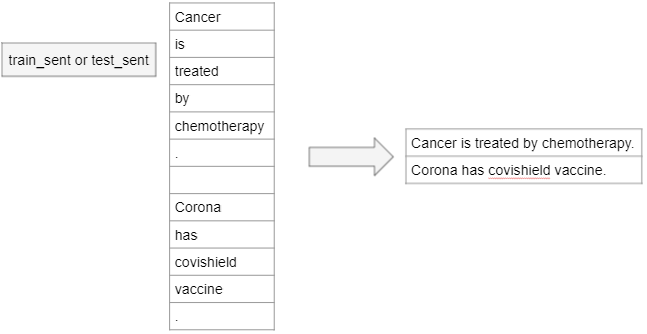

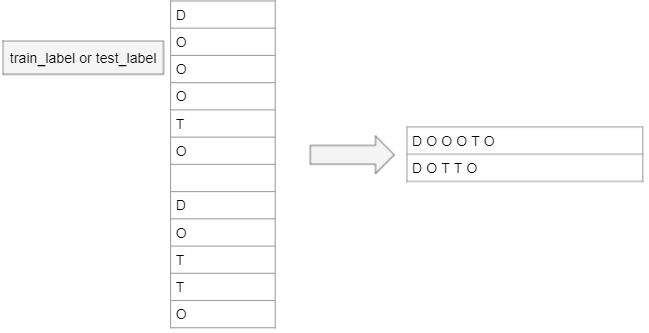

In [37]:
#function to extract sentences from the given file - 
def extracting_sentence(filepath = '', sep = ''):
    try:
        with open(filepath, 'r', encoding = 'utf-8') as file_text:
            if file_text.mode == 'r':
                file_content = file_text.readlines()
        sentences = []
        each_sentence = ''
        for char in file_content:
            content_word = char.strip(sep)
            if content_word == '':
                sentences.append(each_sentence.strip(' '))
                each_sentence = ''
            else:
                each_sentence += content_word + ' '
        
        print('Total Number of Sentences: ', len(sentences), '\n')
        print('*'*50)
        print('Top 5 sentences in the sentences list:\n', sentences[:5])
        return sentences
    except FileNotFoundError:
        print('File not found!!!')

### Count the number of sentences in the processed train and test dataset 

In [38]:
#creating, getting and printing the count of sentences in the train dataset
train_sent = extracting_sentence(filepath = 'train_sent', sep = '\n')

Total Number of Sentences:  2599 

**************************************************
Top 5 sentences in the sentences list:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]


In [39]:
#creating, getting and printing the count of sentences in the test dataset
test_sent = extracting_sentence(filepath = 'test_sent', sep = '\n')

Total Number of Sentences:  1056 

**************************************************
Top 5 sentences in the sentences list:
 ['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']


### Count the number of lines of labels in the processed train and test dataset.

In [40]:
#creating, getting and printing the count of number of line of labels in tain data
train_label = extracting_sentence(filepath = 'train_label', sep = '\n')

Total Number of Sentences:  2599 

**************************************************
Top 5 sentences in the sentences list:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']


In [41]:
#Creating, getting and printing the count of number of line of labels in test data
test_label = extracting_sentence(filepath = 'test_label', sep = '\n')

Total Number of Sentences:  1056 

**************************************************
Top 5 sentences in the sentences list:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [42]:
train_df = pd.DataFrame(columns = ['SENTENCE', 'WORD', 'POS', 'LEMMA', 'LABEL'])
test_df = pd.DataFrame(columns = ['SENTENCE', 'WORD', 'POS', 'LEMMA', 'LABEL'])

In [43]:
#tokenizing Train datframe
nlp= spacy.load("en_core_web_sm")

i=0
j=0
# for each sentence
for sent, label in zip(train_sent, train_label):
    i+=1
    # for each word in a sentence
    for word, lbl in zip(sent.split(), label.split()):
        doc = nlp(word)
        for tokn in doc:
            train_df.loc[j,['SENTENCE','WORD','POS','LEMMA','LABEL']] = [i,tokn.text,tokn.pos_,tokn.lemma_,lbl]
            j+=1

In [44]:
#tokenizing Test datframe
i=0
j=0
# for each sentence
for sent, label in zip(test_sent, test_label):
    i+=1
    # for each word in a sentence
    for word,lbl in zip(sent.split(),label.split()):
        doc = nlp(word)
        for tokn in doc:
            test_df.loc[j,['SENTENCE','WORD','POS','LEMMA','LABEL']] = [i,tokn.text,tokn.pos_,tokn.lemma_,lbl]
            j+=1

In [45]:
train_df

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,All,PRON,all,O
1,1,live,VERB,live,O
2,1,births,NOUN,birth,O
3,1,>,PUNCT,>,O
4,1,or,CCONJ,or,O
...,...,...,...,...,...
48319,2599,vaccine,NOUN,vaccine,T
48320,2599,:,PUNCT,:,O
48321,2599,a,PRON,a,O
48322,2599,second,ADV,second,O


In [46]:
test_df

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,Furthermore,ADV,furthermore,O
1,1,",",PUNCT,",",O
2,1,when,SCONJ,when,O
3,1,all,PRON,all,O
4,1,deliveries,NOUN,delivery,O
...,...,...,...,...,...
19578,1056,globulin,NOUN,globulin,T
19579,1056,for,ADP,for,O
19580,1056,recurrent,NOUN,recurrent,D
19581,1056,spontaneous,ADJ,spontaneous,D


In [47]:
#concatenate train and test dataframes to find the top 25 most common tokens
data_df = pd.concat((train_df, test_df), axis = 0)
#resetting index
data_df.reset_index(inplace = True, drop = True)

In [48]:
data_df

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,All,PRON,all,O
1,1,live,VERB,live,O
2,1,births,NOUN,birth,O
3,1,>,PUNCT,>,O
4,1,or,CCONJ,or,O
...,...,...,...,...,...
67902,1056,globulin,NOUN,globulin,T
67903,1056,for,ADP,for,O
67904,1056,recurrent,NOUN,recurrent,D
67905,1056,spontaneous,ADJ,spontaneous,D


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [81]:
top_25 = data_df[(data_df['POS'] == 'NOUN') | (data_df['POS'] == 'PROPN')]['WORD'].value_counts()[:25]
top_25

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
chemotherapy     88
gene             88
effects          85
results          79
women            77
patient          75
TO_SEE           75
cases            71
risk             71
surgery          71
analysis         70
rate             67
human            67
response         66
survival         65
children         64
effect           64
Name: WORD, dtype: int64

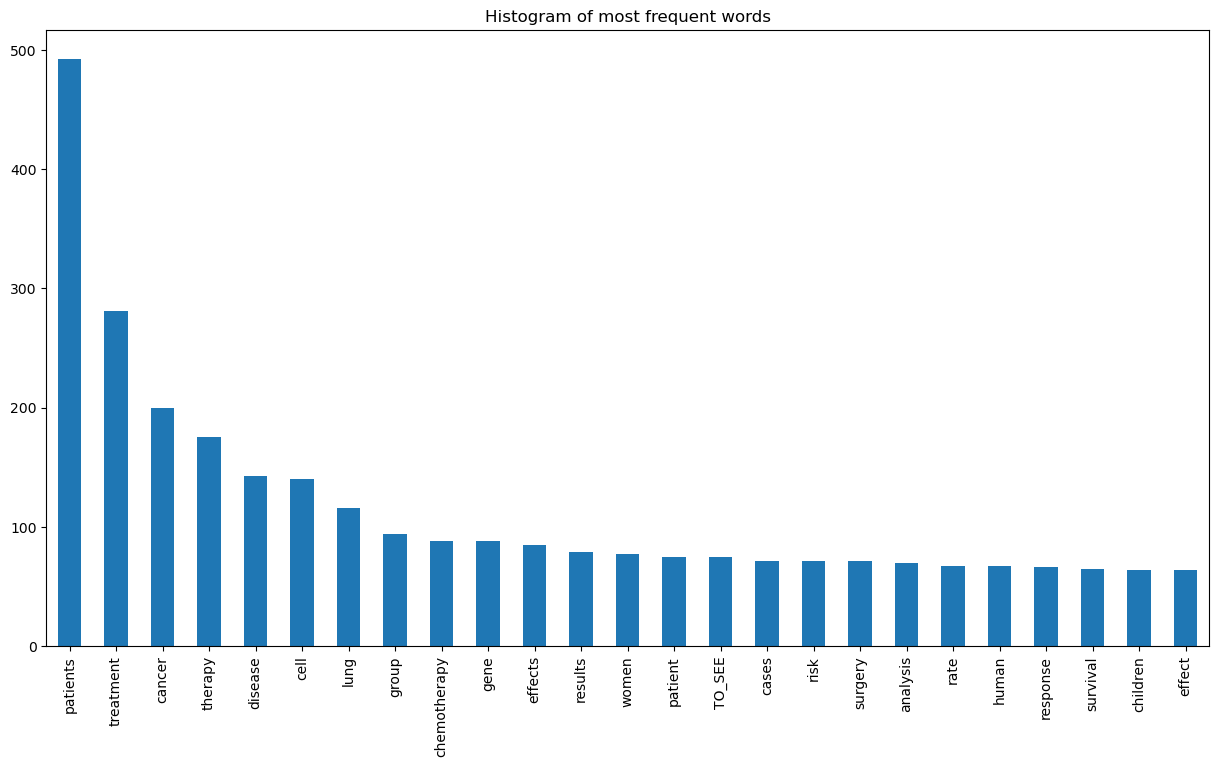

In [82]:
#plotting the most frequent words
plt.figure(figsize=(15, 8))
ax = top_25.plot.bar()
ax.set_title('Histogram of most frequent words')
plt.show()

In [83]:
#printing top 25 most common LEMMA words with NOUN and Proper Noun POS tags
top_25_lemma = data_df[(data_df['POS'] == 'NOUN') | (data_df['POS'] == 'PROPN')]['LEMMA'].value_counts()[:25]
top_25_lemma

patient         587
treatment       316
cancer          226
cell            203
therapy         182
effect          182
disease         172
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            103
trial            91
chemotherapy     91
woman            89
analysis         86
human            85
protein          82
study            82
response         81
risk             78
child            78
mutation         75
Name: LEMMA, dtype: int64

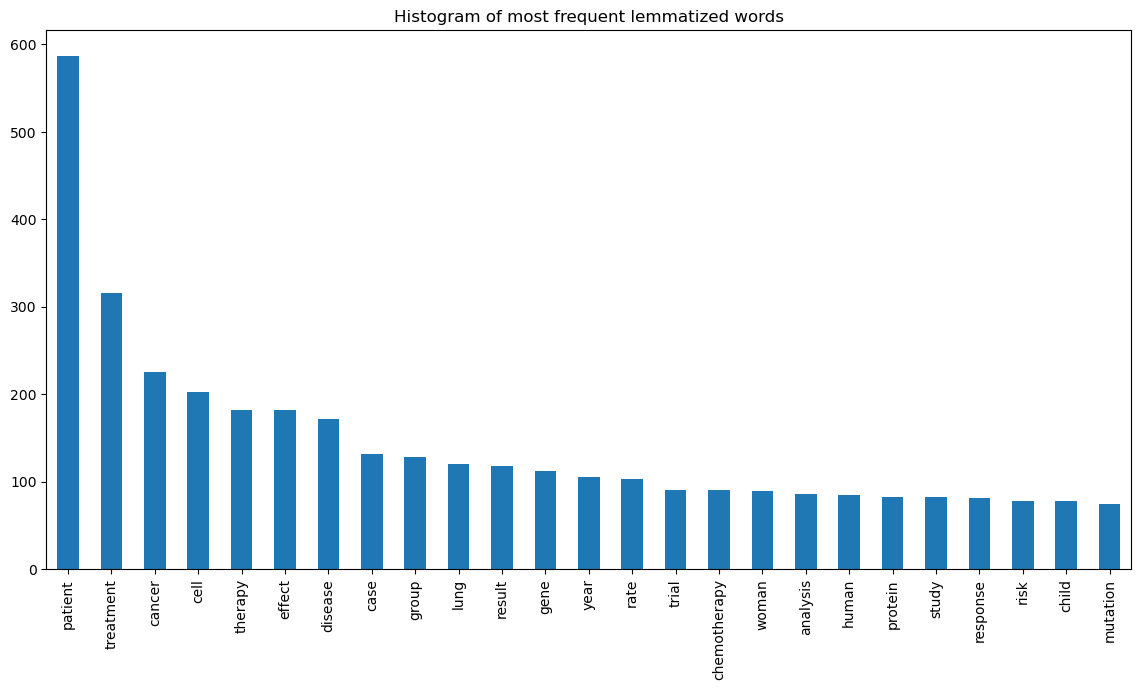

In [84]:
#plotting most frequent words
plt.figure(figsize = (14, 7))
ax = top_25_lemma.plot.bar()
ax.set_title('Histogram of most frequent lemmatized words')
plt.show()

### Observation


*   From both the graphs it looks like the data is mostly for cancer and chemotherapy, followed by surgery are the most sought after treatment

*   The Data also shows diseases mostly in women followed by children

*   Most common organ affected are lungs

In [85]:
#train dataframe with tokens
train_df.head()

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,All,PRON,all,O
1,1,live,VERB,live,O
2,1,births,NOUN,birth,O
3,1,>,PUNCT,>,O
4,1,or,CCONJ,or,O


In [86]:
#test dataframe with tokens
test_df.head()

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,Furthermore,ADV,furthermore,O
1,1,",",PUNCT,",",O
2,1,when,SCONJ,when,O
3,1,all,PRON,all,O
4,1,deliveries,NOUN,delivery,O


## Defining features for CRF

In [87]:
#let's define the features to get the feature value for one word.
def getFeatures_for_oneword(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
      'word.lower=' + word.lower(),
      'word[-2:]=' + word[-2:],
      'word[-3:]=' + word[-3:],
      'word.isupper=%s' % word.isupper(),
      'word.isdigit=%s' % word.isdigit(),
      'word.startsWithCapital=%s' % word[0].isupper(),
      'word.pos=' + pos_tags[pos],
      'word.pos_isnoun=%s' % (pos_tags[pos] in ['NOUN', 'PROPN'])
  ]

  #previous word features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1],
        'prev_word.pos_isnoun=%s' % (pos_tags[pos] in ['NOUN', 'PROPN'])
    ])
  else:
    features.append('BEG')

  if(pos == len(sentence) - 1 ):
      features.append('END')

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [88]:
from inspect import getfile
# Write a code to get features for a sentence.
def getFeatures_for_onesentence(sentence):

  tokenized_sentence = nlp(sentence)
  postags = []

  for each_token in tokenized_sentence:
    postags.append(each_token.pos_)

  sentence_list = sentence.split()
  return [getFeatures_for_oneword(sentence_list, pos, postags) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [89]:
# Write a code to get the labels for a sentence.
def getlabels_in_list_for_onesenetence(labels):
  return labels.split()

In [90]:
example_sentence = train_sent[0]
print(example_sentence)

features = getFeatures_for_onesentence(example_sentence)

features[2]

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


['word.lower=births',
 'word[-2:]=hs',
 'word[-3:]=ths',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=NOUN',
 'word.pos_isnoun=True',
 'prev_word.lower=live',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'prev_word.pos_isnoun=True']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [91]:
X_train = [getFeatures_for_onesentence(sentence) for sentence in train_sent]
X_test = [getFeatures_for_onesentence(sentence) for sentence in test_sent]

In [92]:
print(X_train[0][:3])
print(X_test[0][:3])

[['word.lower=all', 'word[-2:]=ll', 'word[-3:]=All', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=DET', 'word.pos_isnoun=False', 'BEG'], ['word.lower=live', 'word[-2:]=ve', 'word[-3:]=ive', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=ADJ', 'word.pos_isnoun=False', 'prev_word.lower=all', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=True', 'prev_word.pos=DET', 'prev_word.pos_isnoun=False'], ['word.lower=births', 'word[-2:]=hs', 'word[-3:]=ths', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=NOUN', 'word.pos_isnoun=True', 'prev_word.lower=live', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=ADJ', 'prev_word.pos_isnoun=True']]
[['word.lower=furthermore', 'word[-2:]=re', 'word[-3:]=ore', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=ADV'

### Define the labels as the target variable for test and the train dataset

In [93]:
Y_train = [getlabels_in_list_for_onesenetence(labels) for labels in train_label]
Y_test = [getlabels_in_list_for_onesenetence(labels) for labels in test_label]

In [94]:
print(Y_train[0][:3])
print(Y_test[0][:3])

['O', 'O', 'O']
['O', 'O', 'O']


## Build the CRF Model

In [95]:
#build the CRF model
#regularize terma c1 & c2 are chosen as 1.0 and 0.01 after many experiments for the best results based on F1 Score
crf = CRF(max_iterations = 100, c1 = 1.0, c2 = 0.01, all_possible_transitions = False)

try:
  crf.fit(X_train, Y_train)
except AttributeError:
  pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [96]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [97]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average = 'weighted')
print('F1-Score for medical NER DataSet : {0} %'.format(round(f1_score*100, 2)))

F1-Score for medical NER DataSet : 91.43 %


In [98]:
from sys import meta_path
#Calculating the f1-score using test data
precision = metrics.flat_precision_score(Y_test, Y_pred, average = 'weighted')
recall = metrics.flat_recall_score(Y_test, Y_pred, average = 'weighted')
accuracy = metrics.flat_accuracy_score(Y_test, Y_pred)

print('Precision score for the medical NER DataSet : {0} %'.format(round(precision * 100, 2)))
print('Recall score for the medical NER DataSet : {0} %'.format(round(recall * 100, 2)))
print('Accuracy score for the medical NER DataSet : {0} %'.format(round(accuracy * 100, 2)))

Precision score for the medical NER DataSet : 91.4 %
Recall score for the medical NER DataSet : 92.04 %
Accuracy score for the medical NER DataSet : 92.04 %


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

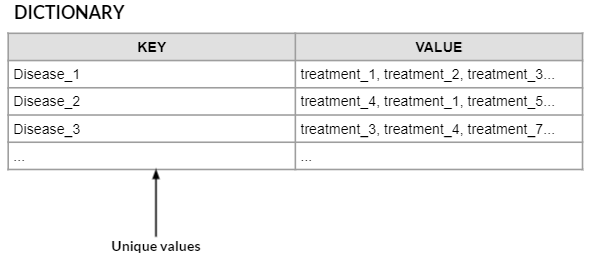

In [99]:
print(Y_pred)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'T', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [100]:
#Creating dictionary for the diseases and recommended treatments for the same

disease_treatment_dict = dict()

for i in range(len(Y_pred)):

  DTO_tag = Y_pred[i]
  diseases = ""
  treatments = ""

  for j in range(len(DTO_tag)):
    if DTO_tag[j] == 'D':
      diseases += test_sent[i].split()[j] + " "
    elif DTO_tag[j] == 'T':
      treatments += test_sent[i].split()[j] + " "

  diseases = diseases.lstrip().rstrip()
  treatments = treatments.lstrip().rstrip()

  if diseases != "" and treatments != "":
    if diseases in disease_treatment_dict.keys():
      treatment_out = list([diseases])
      treatment_out.append(treatments)
      disease_treatment_dict[diseases] = treatment_out
    elif diseases not in disease_treatment_dict.keys():
      disease_treatment_dict[diseases] = treatments

In [101]:
disease_treatment_df = pd.DataFrame(columns = ['Diseases', 'Treatment'])

i = 0
for k, v in disease_treatment_dict.items():
  l = [k, v]
  disease_treatment_df.loc[len(disease_treatment_df.index)] = l
disease_treatment_df.head(5)

,Diseases,Treatment
0,gestational diabetes,good glycemic control
1,hereditary retinoblastoma,radiotherapy
2,epilepsy,Methylphenidate
3,unstable angina or non-Q-wave myocardial infar...,roxithromycin
4,coronary-artery disease,Antichlamydial antibiotics


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [102]:
disease = 'hereditary retinoblastoma'
print("Treatment for Disease '"+ disease +"' is '"+ disease_treatment_dict[disease] +"' ")

Treatment for Disease 'hereditary retinoblastoma' is 'radiotherapy' 
